In [1]:
#Импорт библиотек

import csv
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import itertools as it
import numpy.matlib as nm
from sklearn import metrics
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn import linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#Расчет Somers D

def somers_d(xx,yy,weight = None):
    
    '''
    xx - feature
    yy - target
    weight - weights
    '''
    
    if weight is None: weight = np.ones(len(xx))

    x = st.rankdata(xx)
    y = st.rankdata(yy)
    weight = np.array(weight)
    
    n2_const = sum(weight[:-1]*(sum(weight)-np.cumsum(weight[:-1])))
    K, y_adj = 0, 0

    for i in range(len(weight)-1):
        sign_arr_x = np.sign(x[i]-x[i+1:len(weight)])
        sign_arr_y = np.sign(y[i]-y[i+1:len(weight)])
        ww_arr = weight[i]*weight[i+1:]

        K += sum(ww_arr*sign_arr_x*sign_arr_y)
        y_adj += sum(ww_arr*(1 - abs(sign_arr_y*sign_arr_y)))
        
    return K/(n2_const-y_adj)



In [3]:
#Загрузка исходных данных

a = pd.read_excel(io='Data_for_ESG.xlsx',sheet_name='Data_for_ESG_to_load');
a.head()

,ID,Name,ESG rating,ESG_group,E,E_group,S,S_group,G,G_group,...,Kol_vo_sm_ruk_to_Chist_Akt_norm,Ocenka_rabotodat_norm,LN_Chist_Akt_norm,LN_Divid_potok_norm,Dyn_Chist_Akt_norm,Dyn_Divid_potok_norm,Kol_vo_prosr_to_Divid_potok_norm,Smena_yur_adr_to_Chist_Akt_norm,Fakt_ots_gos_z_i_gos_u_norm,Negat_ton_SMI_to_Upom_SMI_norm
0,1,"ПАО ""НЛМК""",AA,5,AA,5,AA,5,A,5,...,0.497354,-2.067108,0.398938,1.408511,0.069261,0.937432,0.668338,0.423460,-0.386828,-0.155364
1,2,"ПАО ""ПОЛЮС""",AA,5,AAA,5,A,5,A,5,...,0.508764,0.045040,1.240233,-1.257278,-0.286120,-1.337801,-1.564891,0.416075,2.559016,-2.064645
2,3,"ПАО ""Уралкалий""",A,5,BBB,4,AA,5,AA,5,...,0.433277,0.045040,-0.241514,1.101580,1.464150,1.155159,0.664469,0.423460,-0.386828,-1.845897
3,4,"ПАО ""ЭЛ-5 Энерго""",A,5,BBB,4,A,5,AAA,5,...,-0.125174,1.687822,-0.784533,-1.257278,-0.722728,-1.337801,-1.564891,0.285556,-0.386828,0.129448
4,5,"АО ""Полиметалл""",A,5,A,5,A,5,AA,5,...,0.516887,0.749090,-0.374931,0.661670,-0.671885,-0.644388,0.671054,0.365112,2.559016,0.988218


In [24]:
#Перебор всех моделей с метриками

#Добавление столбца из единиц
a['rsh_ones'] = np.ones(a.Ecol_vybr_norm.shape[0])
a.head()
#Переменные для перебора
zz_1 = pd.DataFrame([a.Ecol_vybr_norm,a.rsh_ones]).transpose();
zz_2 = pd.DataFrame([a.Inv_zel_prj_norm,a.rsh_ones]).transpose();
zz_3 = pd.DataFrame([a.Nar_Rs_pr_n_to_D_pot_norm,a.rsh_ones]).transpose();
#Инициализация переменных
rsh_E = a;
q = 0;
vars_E = 3;
zzz = [];
thresh = [];
model_rating_E = [];
p_rating_E_max = [];
error_E = [];
reg_231 = '';
reg_132 = '';
reg_123 = '';
reg_21 = '';

#Перебор моделей для E
for f in range (0,2):
    for ff in range (0,2):
        for fff in range (0,2):
            q = q + 1;
            if ((f < 1) or (ff < 1) or (fff < 1)):
                if (f == 1):
                    vars_E = vars_E-1;       
                if (ff == 1):
                    vars_E = vars_E-1;
                if (fff == 1):
                    vars_E = vars_E-1;
                #Настройка порядковых логистических регрессий
                rsh_E = pd.DataFrame([zz_1[zz_1.columns[f]],zz_2[zz_2.columns[ff]],zz_3[zz_3.columns[fff]]]).drop(['rsh_ones'],axis=0,errors='ignore').transpose()
                mod_log = OrderedModel(a.E_group,rsh_E,
                        distr='logit');
                res_log = mod_log.fit(method='bfgs', disp=False);

                
                #Результаты порядковых логистических регрессий
                predicted = res_log.model.predict(res_log.params, exog=rsh_E);
                
                
                #Получение рейтингов E по наибольшей вероятности нахождения в рейтинге и данная вероятность
                for gg in range(0,res_log.nobs):
                    model_rating_E.append(1);
                    p_rating_E_max.append(predicted[gg,0]);
                    for ggg in range(1,5):
                        if (predicted[gg,ggg] > p_rating_E_max[gg]):
                            model_rating_E[gg] = ggg+1;
                            p_rating_E_max[gg] = predicted[gg,ggg];
                
                #Расчет Somers'D на обучении модели
                Somers_D_build = somers_d(model_rating_E,a.E_group,weight = None);
                
                #Расчет доли наблюдений с 0,0-1 и 0-1-2 нотчами ошибок
                kol_vo_0 = 0;
                kol_vo_0_1 = 0;
                kol_vo_0_1_2 = 0;
                
                for gf in range(0,res_log.nobs):
                    error_E.append(abs(a.E_group[gf] - model_rating_E[gf]));
                    if (error_E[gf] == 0):
                        kol_vo_0 = kol_vo_0 + 1;
                    if (error_E[gf] <= 1):
                        kol_vo_0_1 = kol_vo_0_1 + 1;
                    if (error_E[gf] <= 2):
                        kol_vo_0_1_2 = kol_vo_0_1_2 + 1;
                
                dolya_error_0_notch = kol_vo_0/res_log.nobs;
                dolya_error_0_1_notch = kol_vo_0_1/res_log.nobs; 
                dolya_error_0_1_2_notch = kol_vo_0_1_2/res_log.nobs;
                
                #Формирование итоговой выгрузки по итогам перебора
                zzzz = np.array(pd.DataFrame([zz_1[zz_1.columns[f]],zz_2[zz_2.columns[ff]],zz_3[zz_3.columns[fff]]]).drop(['rsh_ones'],axis=0,errors='ignore').transpose())
                
                if (vars_E == 3):   
                    #Корректировка свободных членов регрессии по причине их смещения в Питоне
                    th_params = [res_log.params[3],res_log.params[4],res_log.params[5],res_log.params[6]];
                    thresh = np.concatenate((th_params[:1], np.exp(th_params[1:]))).cumsum();
                    
                  
                    #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                    reg_231 = linear_model.LinearRegression();
                    reg_231.fit(np.array([zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,0]]).transpose());
                    reg_231_score = reg_231.score(np.array([zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,0]]).transpose());            
                    reg_132 = linear_model.LinearRegression();
                    reg_132.fit(np.array([zzzz[:,0],zzzz[:,2]]).transpose(), np.array([zzzz[:,1]]).transpose());
                    reg_132_score = reg_132.score(np.array([zzzz[:,0],zzzz[:,2]]).transpose(), np.array([zzzz[:,1]]).transpose()); 
                    reg_123 = linear_model.LinearRegression();
                    reg_123.fit(np.array([zzzz[:,0],zzzz[:,1]]).transpose(), np.array([zzzz[:,2]]).transpose());
                    reg_123_score = reg_123.score(np.array([zzzz[:,0],zzzz[:,1]]).transpose(), np.array([zzzz[:,2]]).transpose()); 
                    #Вывод результатов перебора для моделей с 3 факторами
                    zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],mod_log.exog_names[2],abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),
                                min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]))),
                                res_log.nobs,Somers_D_build,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],-res_log.params[1],-res_log.params[2],thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2])))),1/(1-reg_231_score),1/(1-reg_132_score),1/(1-reg_123_score),max(1/(1-reg_231_score),1/(1-reg_132_score),1/(1-reg_123_score))]); 
                if (vars_E == 2):
                    #Корректировка свободных членов регрессии по причине их смещения в Питоне
                    th_params = [res_log.params[2],res_log.params[3],res_log.params[4],res_log.params[5]];
                    thresh = np.concatenate((th_params[:1], np.exp(th_params[1:]))).cumsum();
                    #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                    reg_21 = linear_model.LinearRegression();
                    reg_21.fit(np.array([zzzz[:,1]]).transpose(), np.array([zzzz[:,0]]).transpose());
                    reg_21_score = reg_21.score(np.array([zzzz[:,1]]).transpose(), np.array([zzzz[:,0]]).transpose());
                    #Вывод результатов перебора для моделей с 2 факторами
                    zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],'',abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),'',
                                min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]))),
                                res_log.nobs,Somers_D_build,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],-res_log.params[1],0,thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),'',max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1])))),1/(1-reg_21_score),1/(1-reg_21_score),'',1/(1-reg_21_score)]);
                if (vars_E == 1):
                    #Корректировка свободных членов регрессии по причине их смещения в Питоне
                    th_params = [res_log.params[1],res_log.params[2],res_log.params[3],res_log.params[4]];
                    thresh = np.concatenate((th_params[:1],np.exp(th_params[1:]))).cumsum();
                    #Вывод результатов перебора для моделей с 1 фактором
                    
                    zzz.append([mod_log.exog_names[0],'','',1,'','',1,1,res_log.nobs,Somers_D_build,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],
                               0,0,thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),'','',2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),1,'','',1]);
                vars_E_pre = vars_E;
                vars_E = 3;
                model_rating_E = [];
                p_rating_E_max = [];
                error_E = [];
                
#Вывод результатов перебора в Эксель                
zzz_pd=pd.DataFrame(zzz);
zzz_pd
#zzz_pd.to_excel(excel_writer = "Perebor_E.xlsx",header=['Risk_factor_1','Risk_factor_2','Risk_factor_3','Ves_1','Ves_2','Ves_3','Ves_min','Ves_max','count_obs_build','Somers_D_build','dolya_error_0_notch','dolya_error_0_1_notch','dolya_error_0_1_2_notch',
                                                                                                                # 'LogL_build','pseudo_Rsq_build','AIC_build','Regr_koef_1','Regr_koef_2','Regr_koef_3','Intercept_1','Intercept_2','Intercept_3','Intercept_4','p_value_1','p_value_2','p_value_3','p_value_vars_max','VIF_1','VIF_2','VIF_3','VIF_max']);

/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ord

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,Ecol_vybr_norm,Inv_zel_prj_norm,Nar_Rs_pr_n_to_D_pot_norm,0.022171,0.933511,0.044318,0.022171,0.933511,99,0.407382,...,2.302099,5.212446,8.462314e-01,0.0,0.691897,8.462314e-01,1.075687,1.044779,1.036259,1.075687
1,Ecol_vybr_norm,Inv_zel_prj_norm,,0.013049,0.986951,,0.013049,0.986951,99,0.407382,...,2.298331,5.218024,9.114393e-01,0.0,,9.114393e-01,1.039378,1.039378,,1.039378
2,Ecol_vybr_norm,Nar_Rs_pr_n_to_D_pot_norm,,0.580787,0.419213,,0.419213,0.580787,99,0.000000,...,1.558842,3.017791,8.771242e-02,0.218224,,2.182242e-01,1.030902,1.030902,,1.030902
3,Ecol_vybr_norm,,,1.000000,,,1.000000,1.000000,99,0.000000,...,1.531784,2.978065,1.393485e-01,,,1.393485e-01,1.000000,,,1.000000
4,Inv_zel_prj_norm,Nar_Rs_pr_n_to_D_pot_norm,,0.959438,0.040562,,0.040562,0.959438,99,0.407382,...,2.300404,5.213715,1.767884e-08,0.716375,,7.163753e-01,1.001280,1.00128,,1.001280
5,Inv_zel_prj_norm,,,1.000000,,,1.000000,1.000000,99,0.407382,...,2.297592,5.218769,1.566993e-08,,,1.566993e-08,1.000000,,,1.000000
6,Nar_Rs_pr_n_to_D_pot_norm,,,1.000000,,,1.000000,1.000000,99,0.000000,...,1.516786,2.951087,3.790591e-01,,,3.790591e-01,1.000000,,,1.000000


In [18]:
rsh_E

,Nar_Rs_pr_n_to_D_pot_norm
0,0.678396
1,-1.537776
2,0.667710
3,-1.537776
4,0.678396
...,...
94,-1.537776
95,-1.537776
96,0.214701
97,-1.527395


In [6]:
#Оптимальная модель для рейтинга E
mod_log = OrderedModel(a.E_group,a.Inv_zel_prj_norm,
                        distr='logit')
res_log = mod_log.fit(method='bfgs', disp=False)
res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                E_group   Log-Likelihood:                -90.539
Model:                   OrderedModel   AIC:                             191.1
Method:            Maximum Likelihood   BIC:                             204.1
Date:                Sat, 23 Sep 2023                                         
Time:                        14:02:46                                         
No. Observations:                  99                                         
Df Residuals:                      94                                         
Df Model:                           5                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Inv_zel_prj_norm     1.8639      0.330      5.654      0.000       1.218       2.510
1/2                  0.0716      0.252      0.285      0.776      -0.421       0.565
2/3                  0.1291      0.247      0.522      0.602      -0.356       0.614
3/4                  0.0845      0.383      0.221      0.825      -0.665       0.834
4/5                  1.0720      0.270      3.963      0.000       0.542       1.602
====================================================================================
"""

In [7]:
#Корректировка свободных членов регрессии по причине их смещения в Питоне
th_params = [res_log.params[1],res_log.params[2],res_log.params[3],res_log.params[4]];
thresh = np.concatenate((th_params[:1],
                                 np.exp(th_params[1:]))).cumsum();
print(thresh)
dir(res_log);

[0.07163015 1.20938256 2.29759182 5.21876946]


In [8]:
#Результаты применения оптимальной порядковой логистической регрессии
predicted = res_log.model.predict(res_log.params, exog=a[['Inv_zel_prj_norm']]);

qqq_pred=pd.DataFrame(predicted);
#qqq_pred.to_excel(excel_writer = "test123.xlsx");
model_rating_E = [];
p_rating_E_max = [];

for gg in range(0,res_log.nobs):
                    model_rating_E.append(1);
                    p_rating_E_max.append(predicted[gg,0]);
                    for ggg in range(1,5):
                        if (predicted[gg,ggg] > p_rating_E_max[gg]):
                            model_rating_E[gg] = ggg+1;
                            p_rating_E_max[gg] = predicted[gg,ggg];

model_rating_E_pred=pd.DataFrame(model_rating_E);
#model_rating_E_pred.to_excel(excel_writer = "test1234.xlsx");

print(qqq_pred);
print(model_rating_E);

Score_E=a.Inv_zel_prj_norm*res_log.params[0];
Score_E_pred=pd.DataFrame(Score_E);
Score_E_pred.to_excel(excel_writer = "Score_E.xlsx");

           0         1         2         3         4
0   0.013168  0.026797  0.070032  0.586443  0.303560
1   0.013168  0.026797  0.070032  0.586443  0.303560
2   0.013168  0.026797  0.070032  0.586443  0.303560
3   0.013168  0.026797  0.070032  0.586443  0.303560
4   0.013168  0.026797  0.070032  0.586443  0.303560
..       ...       ...       ...       ...       ...
94  0.701671  0.178391  0.076050  0.041422  0.002467
95  0.701671  0.178391  0.076050  0.041422  0.002467
96  0.701671  0.178391  0.076050  0.041422  0.002467
97  0.701671  0.178391  0.076050  0.041422  0.002467
98  0.701671  0.178391  0.076050  0.041422  0.002467

[99 rows x 5 columns]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


In [9]:
#Расчет Somers'D по оптимальной модели для рейтинга E
Somers_D_opt = somers_d(model_rating_E,a.E_group,weight = None);
print(Somers_D_opt);

0.4073820915926179


In [10]:
#Формирование данных по фактической и модельной диаграммам для рейтинга E
graph_1 = np.array(a.groupby('E_group').agg('count').ID/a.shape[0]);
print(graph_1);
a['model_rating_E'] = model_rating_E;
graph_2 = np.array(a.groupby('model_rating_E').agg('count').ID/a.shape[0]);
print(graph_2);

[0.5959596  0.15151515 0.07070707 0.13131313 0.05050505]
[0.84848485 0.15151515]


Text(0, 0.5, 'Частота')

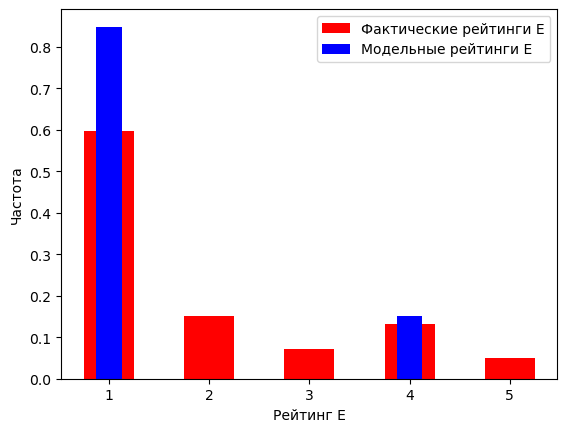

In [11]:
#Построение фактической и модельной диаграмм для рейтинга E
plt.bar([1,2,3,4,5],graph_1,color='red',width=0.5);
plt.bar([1,4],graph_2,color='blue',width=0.25);
plt.legend(['Фактические рейтинги E','Модельные рейтинги E']);
plt.xlabel('Рейтинг E', color='black')
plt.ylabel('Частота',color='black')